In [1]:
%matplotlib widget
import torch
import numpy as np
import torch.optim as optim
from simple_pinn import SimplePINN
import matplotlib.pyplot as plt
import scipy.io

In [2]:
model = SimplePINN(
    2, [20, 20, 20], 1
)  # the inputs are the ordered tuple (x, t); the output is u(x, t)
print(model)

SimplePINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
  )
  (head): Linear(in_features=20, out_features=1, bias=True)
)


In [3]:
X_DOMAIN = (-1.0, 1.0)  # x boundaries of the problem
T_DOMAIN = (0.0, 1.0)  # t boundaries of the problem

In [4]:
def compute_loss(model, batch_size):
    # sample the collocation points
    x = (
        torch.rand(batch_size, 1, requires_grad=True) * (X_DOMAIN[1] - X_DOMAIN[0])
        + X_DOMAIN[0]
    )
    t = (
        torch.rand(batch_size, 1, requires_grad=True) * (T_DOMAIN[1] - T_DOMAIN[0])
        + T_DOMAIN[0]
    )
    # forward pass through the model at the collocation points
    input = torch.cat((x, t), dim=1)
    u = model(input)
    # evaluate the residual loss at the collocation points
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[
        0
    ]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[
        0
    ]
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]
    residual = u_t + u * u_x - (0.01 / torch.pi) * u_xx
    residual_loss = torch.mean(torch.square(residual))

    # sample the initial condition points
    x_0 = torch.rand(batch_size, 1) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    t_0 = torch.zeros_like(x_0)
    # forward pass through the model at the initial condition points
    input_0 = torch.cat((x_0, t_0), dim=1)
    u_0_pred = model(input_0)
    # evaluate the initial condition loss
    u_0_exact = -torch.sin(torch.pi * x_0)
    init_loss = torch.mean(torch.square(u_0_pred - u_0_exact))

    # sample the boundary condition points
    x_lb = torch.ones(batch_size, 1) * X_DOMAIN[0]
    x_rb = torch.ones(batch_size, 1) * X_DOMAIN[1]
    t = torch.rand(batch_size, 1) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]
    # forward pass through the model at the boundary condition points
    input_lb = torch.cat((x_lb, t), dim=1)
    input_rb = torch.cat((x_rb, t), dim=1)
    u_lb_pred = model(input_lb)
    u_rb_pred = model(input_rb)
    # evaluate the boundary condition loss
    bc_loss = torch.mean(torch.square(u_lb_pred - u_rb_pred))

    # compute the total loss
    loss = residual_loss + init_loss + bc_loss
    return loss

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 10_000
n_epochs = 20_000

In [6]:
for epoch in range(n_epochs):
    loss = compute_loss(model, batch_size)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1} | Loss: {loss.item():.6f}")

Epoch 1 | Loss: 0.497759
Epoch 2 | Loss: 0.493673
Epoch 3 | Loss: 0.485669
Epoch 4 | Loss: 0.488707
Epoch 5 | Loss: 0.483415
Epoch 6 | Loss: 0.478283
Epoch 7 | Loss: 0.479200
Epoch 8 | Loss: 0.479410
Epoch 9 | Loss: 0.476560
Epoch 10 | Loss: 0.477255
Epoch 11 | Loss: 0.476557
Epoch 12 | Loss: 0.477701
Epoch 13 | Loss: 0.480152
Epoch 14 | Loss: 0.481445
Epoch 15 | Loss: 0.482336
Epoch 16 | Loss: 0.472124
Epoch 17 | Loss: 0.478886
Epoch 18 | Loss: 0.474610
Epoch 19 | Loss: 0.478843
Epoch 20 | Loss: 0.473757
Epoch 21 | Loss: 0.481063
Epoch 22 | Loss: 0.471877
Epoch 23 | Loss: 0.468306
Epoch 24 | Loss: 0.469850
Epoch 25 | Loss: 0.475547
Epoch 26 | Loss: 0.473558
Epoch 27 | Loss: 0.473414
Epoch 28 | Loss: 0.467984
Epoch 29 | Loss: 0.473195
Epoch 30 | Loss: 0.468052
Epoch 31 | Loss: 0.473687
Epoch 32 | Loss: 0.473570
Epoch 33 | Loss: 0.470566
Epoch 34 | Loss: 0.474620
Epoch 35 | Loss: 0.471761
Epoch 36 | Loss: 0.462898
Epoch 37 | Loss: 0.470281
Epoch 38 | Loss: 0.467761
Epoch 39 | Loss: 0.47

In [7]:
# load the exact solution for comparison
data = scipy.io.loadmat("../PINNs/appendix/Data/burgers_shock.mat")
x = torch.tensor(data["x"].flatten(), dtype=torch.float32)  # 256
t = torch.tensor(data["t"].flatten(), dtype=torch.float32)  # 100
u_exact = torch.tensor(np.real(data["usol"]), dtype=torch.float32)  # u[x, t]: 256 x 100

In [8]:
# evaluate the model prediction on the same grid as the exact solution
X, T = torch.meshgrid(x, t, indexing="ij")
x_sample = torch.reshape(X, (-1, 1))
y_sample = torch.reshape(T, (-1, 1))
input = torch.cat((x_sample, y_sample), dim=1)
u_pred = model(input)
u_pred = u_pred.reshape(u_exact.shape)

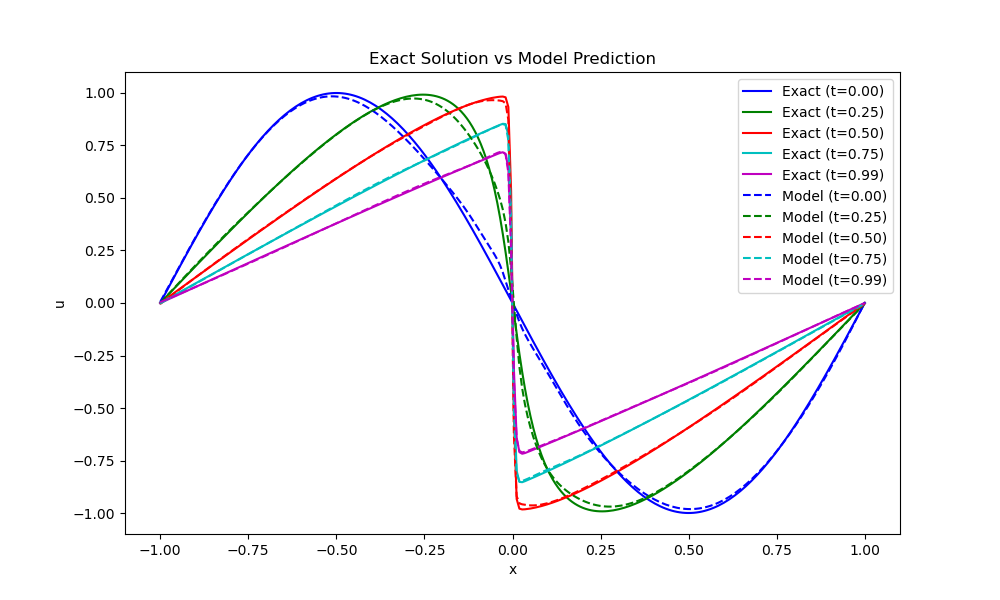

In [9]:
# Define the sample times
sample_times = [0, 25, 50, 75, 99]

# Plot the exact solution
plt.figure(figsize=(10, 6))
colors = ["b", "g", "r", "c", "m"]  # Define colors for each time
for i, t_idx in enumerate(sample_times):
    plt.plot(x, u_exact[:, t_idx], color=colors[i], label=f"Exact (t={t[t_idx]:.2f})")

# Plot the model prediction
for i, t_idx in enumerate(sample_times):
    plt.plot(
        x,
        u_pred[:, t_idx].detach().numpy(),
        "--",
        color=colors[i],
        label=f"Model (t={t[t_idx]:.2f})",
    )

plt.xlabel("x")
plt.ylabel("u")
plt.title("Exact Solution vs Model Prediction")
plt.legend()
plt.show()